# Further explanation and dicussion of the content of this notebook are provided in the following blog post "BERTopic & Flashback threads on COVID-19 vaccination" at SpråkbankenText: <a href="https://spraakbanken.gu.se/en/blog/20230127-bertopic-flashback-threads-on-covid-19-vaccination">BLOG</a>.
The dataset consisting of Flashback posts about COVID-19 vaccines and vaccination, published during 2021.
This notebook covers:
* An introductory exploration and basic overview of the dataset
* Sampling of a representative subset of the data for our modeling.
* Fitting the BERTopic model.
* Visualizing, exploring and manipulating the results in various ways.
<center><br> <img src="https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png" width="10%"></center>

## Downloading the dataset and an extended list of Swedish and (a few) English stop words

We will use a [terminal command](https://en.wikipedia.org/wiki/Command-line_interface) to download the Flashback dataset and make it accessible within the notebook. The user can prefix an exclamation mark `!` before any commands in a code cell to indicate they want to use the terminal. We'll use the command line tool [cURL](https://en.wikipedia.org/wiki/CURL) to download a file from a URL. We also download a file `extended_stopwords.txt` containing a list of Swedish, and some English [stop words](https://en.wikipedia.org/wiki/Stop_word). These contain words like conjunctions, pronouns or prepositions, which are typically non-informative, and which we'd like to filter out. For BERTopic *stop word removal is performed as an optional post-processing* step, done ***after*** the model has been fitted. The choice of stop words -- in other words -- does not in any way affect the topics detected when using BERTopic.

In [1]:
# The Flashback dataset - one smaller, 2500 posts (randomly extracted from the larger one) and a larger one
#!curl -L https://raw.githubusercontent.com/DimitrisKokkinakis/swedish-notebooks/main/textual-resources/FB_2000_VaccinPosts.csv --output fb_posts.csv
!curl -L https://raw.githubusercontent.com/DimitrisKokkinakis/swedish-notebooks/main/textual-resources/FB_all_VaccinPosts.csv  --output fb_posts.csv
# Extended Swedish stopwords
!curl -L https://raw.githubusercontent.com/DimitrisKokkinakis/swedish-notebooks/main/lexical-resources/sv_stopwords_extended.txt --output extended_stopwords.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5062k  100 5062k    0     0  5706k      0 --:--:-- --:--:-- --:--:-- 5707k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10041  100 10041    0     0  22109      0 --:--:-- --:--:-- --:--:-- 22068


## Reading and displaying the data using the `pandas` library

The [`pandas`](https://pandas.pydata.org/) library is a standard data analysis tool for reading, processing and manipulating data in Python. We read the dataset file `fb_posts.csv` and save it to a variable we name `df`, after which we display the first 5 rows of the dataframe by issuing the command `df.head()`.

A brief explanation of some column variables:

* **id**: Unique id that identifies each post/document.
* **mydate**: Date in the format YYYY-mm-dd.
* **author**: The author's nickname that wrote the post.
* **posts**: The number of published posts by the `author`.
* **text**: Contains the text of the post.

In [2]:
import pandas as pd
from io import StringIO
import requests

df=pd.read_csv("fb_posts.csv", sep = "\t")
# Convert also the mydate column to the proper date format
df["mydate"] = pd.to_datetime(df["mydate"])

print(f"The dataset consists of a total of {len(df)} posts.")
df.info()
df.shape

# Split the text column by space and count a unique estimation of tokens
unique_words = set()
for text in df['text']:
    for word in text.split():
        unique_words.add(word)
num_unique_words = len(unique_words)
print(f"The dataset consists of roughly {num_unique_words} unique tokens.")

The dataset consists of a total of 13462 posts.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13462 entries, 0 to 13461
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      13462 non-null  int64         
 1   mydate  13462 non-null  datetime64[ns]
 2   author  13462 non-null  object        
 3   posts   13462 non-null  object        
 4   text    13462 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 526.0+ KB
The dataset consists of roughly 67136 unique tokens.


In [3]:
# Display the 5 first rows of the dataframe
df.head()

,id,mydate,author,posts,text
0,1,2021-04-26,rtyuio,#3287,Facebook förbjuder grupp som diskuterar bieffe...
1,2,2021-04-26,Helge.Palmcrantz,#19825,Även om sådana grupper brukar styras och överr...
2,3,2021-04-26,roofofglass,#532,Å ena sidan har folk inte rätt till nåt på Fac...
3,4,2021-04-26,swebarb,#15996,"Facebook är ju det mest PK man kan komma, va o..."
4,5,2021-04-26,Rasande-Rose,#4284,Har stängt min facebook. Känns skönt att ta_bo...


Let us explore the frequency distributions (top-10) over the column '***author***'

In [4]:
df["author"].value_counts()[0:10]

Intensivtklok    250
MrArtur          222
korrektamund0    172
Leland1979       145
arbetet          144
RostigHink       142
Lost.Villain     137
-GG              123
Porky123         114
borskungen       104
Name: author, dtype: int64

In [5]:
#These variables are used later in the visualizations
df["mydate"] = pd.to_datetime(df["mydate"], format='%Y-%m-%d')
timestamps = df["mydate"].dt.month.tolist() # Extract the month each post
classes = df["author"].tolist()             # Posts' "affiliation" of authors

### Documents that might be longer than our model can handle!

One issue we'll be running into when doing topic modeling with transformer based neural networks, is that these networks have a maximum text ("token") length limit they are able to process at a time. For our Swedish sentence-transformer, this limit is 256 tokens (corresponding to about 200 words). In order to proceed, we first need to make a choice of how documents exceeding this length limit should be processed. One reasonable option is to cut long posts into several chunks of a certain length. Below, we create two functions called `chunks()` and `split_text()` which will split our document into individual words, and allow us to specify a number of words (`nr_words`) split point for how long a text chunk should be.

In [6]:
def chunks(text, chunk_len):
    """
    Cut up the original text into multiple chunks that are a maximum of
    chunk_len long.
    """
    return [text[i : i + chunk_len] for i in range(0, len(text), chunk_len)]

def split_text(df, nr_words_per_chunk=220):
    df["text"] = df["text"].apply(lambda x: chunks(x.split(), nr_words_per_chunk))
    df = df.explode("text").reset_index(drop=True) # Expand each chunk into its own individual row
    df["text"] = df["text"].str.join(" ")          # Join the words back together
    return df

largest length of a string: 296


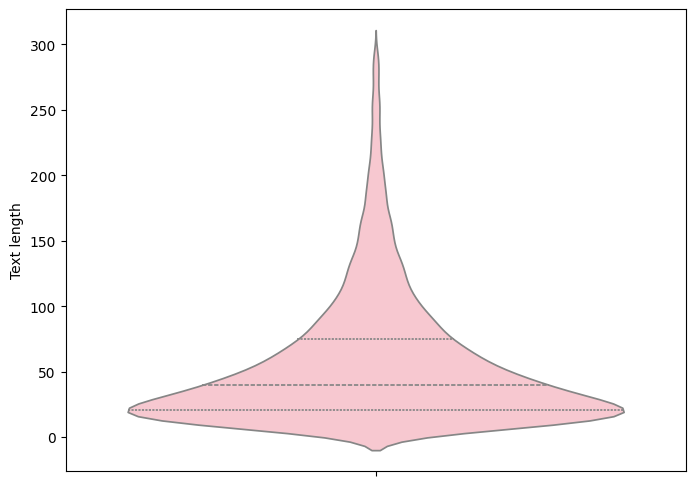

In [7]:
import re
import matplotlib.pyplot as plt
import seaborn as sns

def clean(text):
#Remove URLs from the text string
    output = re.sub(r'https://\S*','', text)
#Remove duplicated punctuation
    output = re.sub(r'([!()\-{};:,<>./?@#$%\^&*_~]){2,}', lambda x: x.group()[0], output)
#Remove string if length<4
    if len(output.split()) < 4:
        output = ''
    return output

df["cleaned_text"] = df["text"].apply(clean)
# [(i+1,t) for i, t in enumerate(df["cleaned_text"][:5])]

#check length
length = [len(i.split()) for i in df["cleaned_text"]]
print('largest length of a string:', max(length))

plt.figure(figsize=(8,6))
sns.violinplot(y = length, inner="quart", color="pink")
plt.ylabel('Text length')
plt.show()

After chunking the documents, we now have (possibly) a bit more observations than we started with.

In [8]:
df = split_text(df)
df = df.dropna(axis=0, subset=["text"]) # Drop possible posts with no text.

print(f"""Dataframe now contains {len(df)} observations.
This time including the -two- first 220 words of the dataset's text.""")

Dataframe now contains 13678 observations.
This time including the -two- first 220 words of the dataset's text.


Let's take a look at the textual content of some of these posts.

In [10]:
df[["author","text"]][1000:1010]

,author,text
1000,Jonny.Boj,Detta är den mest intressanta flashbacktråden ...
1001,Raglefant,Vet inte om jag angav fel artikel och jag hitt...
1002,Doosing,Det har säkert sagts innan i tråden men många ...
1003,fittslem,"Vi är alla magnetiska, inpotenta, har förlorat..."
1004,Dille24,Ett ännu större mysterium är att vi saknar tre...
1005,MrArtur,Prova med en vaccineffektivitet mot dödsfall p...
1006,-GG,Alldeles för många gömda biverkningar. Som sju...
1007,Lamron,Fick bli plastdinosaurien eftersom jag är stor...
1008,Downtownkid67,"Just det, därför_att vaccin är framtaget utan ..."
1009,prostetnic,"Ja, det är väl självklart? Det är alltid några..."


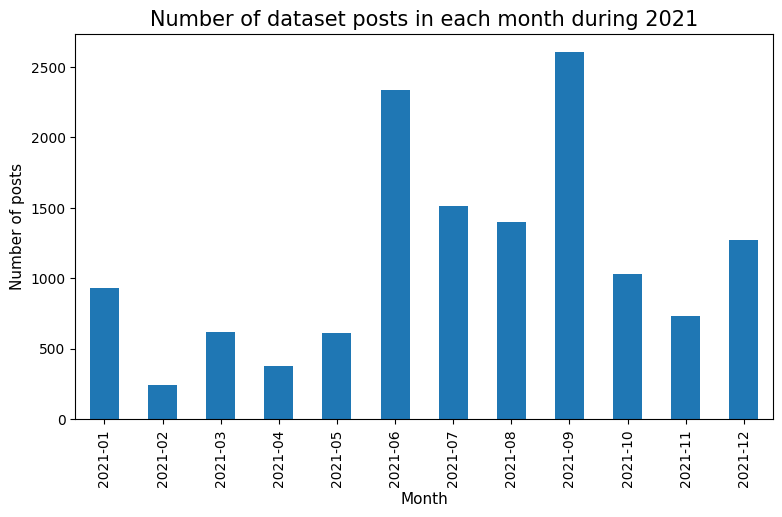

In [11]:
# retain df within 2021
df['mydate'] = pd.to_datetime(df['mydate'])
df = df[df['mydate'] >= '2021-01-01']
df = df[df['mydate'] < '2021-12-31']

# plot graph for number of articles in each month from 1/1 2021 to 31/12 2021 in bins of 1 month
df_copy = df.copy()
df_copy['mydate'] = pd.to_datetime(df_copy['mydate'])
df_copy['mydate'] = df_copy['mydate'].dt.to_period('M')
articles_per_month = df_copy['mydate'].value_counts().sort_index()
df_copy['mydate'].value_counts().sort_index().plot(kind='bar', figsize=(9,5))
plt.title('Number of dataset posts in each month during 2021', fontsize=15)
plt.xlabel('Month', fontsize=11)
plt.ylabel('Number of posts', fontsize=11)
plt.show()

del df_copy

## Modeling: Fitting a BERTopic model

Let's fit a BERTopic model on the Flashback posts. In order to do this we need to ensure the [`bertopic`](https://maartengr.github.io/BERTopic/index.html) python package is installed in our current Colab notebook environment. We can check which python packages are pre-installed by issuing the command `!pip list`. Since `bertopic` is not included in our programming environment, we install it ourselves using the install command listed on [BERTopic's website](https://maartengr.github.io/BERTopic/index.html).

In [12]:
!pip install bertopic==0.16.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 69.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 27.2 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731

We proceed to load some necessary python libraries.

In [16]:
import os
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP # In case we want to make results deterministic and reproducible

In [17]:
import pandas as pd
from string import punctuation

# Get all unique words
df['text'].str.split().explode().unique()
# Get all unique -non-tokenized- words with frequency counts
df['text'].str.split().explode().value_counts()

att                  24348
är                   20273
det                  16695
som                  16422
och                  16316
                     ...  
NZ?                      1
välfärdssjukdomar        1
hanterade                1
passeras                 1
fritid.                  1
Name: text, Length: 67118, dtype: int64

### Read the list of the Swedish (and some English) stop words

We read the list of stopwords from the file `extended_stopwords.txt` which we downloaded earlier. These will be used to clean up the topic representations and filter out what in this context amounts to mostly non-informative parts of speech. Whereas the choice of stopwords has an effect on the resulting topics in traditional topic modeling, for BERTopic it is actually a ***post-processing*** step that is done after the clustering of topics has already been performed. Thus, in BERTopic, stopwords have basically ***no effect*** on the topics that result from fitting the model. Here, stop words are *only* used to clean up the list of representative words for each topic, and get rid of words we consider to be non-informative.

In [18]:
# In general, BERTopic will also work well without specifying stop words.
with open("extended_stopwords.txt", 'r') as f:
    stop = f.read().splitlines()
# Obs! the words 'vaccin*' are added as stopWords since these were extremely frequent
import pandas as pd
print(pd.read_csv('extended_stopwords.txt',nrows=5, header=None))

         0
0        a
1    about
2    above
3  absolut
4   across


### Parameters (showcase some of the functionality of BERTopic) before we **Fit** the model

Once the data is organized, it's  time to fit our model. Fitting a BERTopic model is quite straightforward. All we really need to do code wise is:

  1. A list of documents.
  2. Load a relevant sentence transformer model to extract embeddings.
  3. - Initialize BERTopic with the settings we want to use.
     - (Optional) Use Maximal Marginal Relevance as a further post processing step to reduce redundant words in our topic representations (e.g. when both "patient" and "patients" appear a lot in documents, we keep only one as a representative word).
  4. Issue the command to fit the model.  

There are ways to tweak the different components of the model in a more explicit manner. One example is using a different clustering algorithm or [providing different parameters for the clustering algorithm](https://maartengr.github.io/BERTopic/getting_started/clustering/clustering.html). In most cases, however, the default settings will work very well. If you are interested in seeing the different steps of the model laid out explicitly, there is a good explanation to be found on the [BERTopic website](https://maartengr.github.io/BERTopic/algorithm/algorithm.html#code-overview) that explains the algorithm in greater detail.

Below, we set `calculate_probabilities` to `True`, specifying that the BERTopic model should calculate and return the probabilities for any given document belonging to all the different possible topics. This is a setting which increases the computational cost and makes training a model both take longer and consume more memory, but including it will allow us to create some of the visualizations you will see later. If you are more interested in training a model quickly, it's better to set `calculate_probabilities` to `False`.

We'll be using KBLab's own Swedish sentence-transformer ["KBLab/sentence-bert-swedish-cased"](https://huggingface.co/KBLab/sentence-bert-swedish-cased) to create numerical vector representations ("embeddings") of our sentences/paragraphs. You can read more about how this model was trained in a [blog post](https://kb-labb.github.io/posts/2021-08-23-a-swedish-sentence-transformer/) on KBLab's blog.

In [19]:
documents = df["text"].tolist() # Documents as a list

# Step-1: Extract embeddings
# Load KBLab's Swedish sentence transformer model
sentence_model = SentenceTransformer("KBLab/sentence-bert-swedish-cased", device="cpu")

# Step-2: Dimensionality reduction
umap_model = UMAP(n_neighbors=10, n_components=5,
                  min_dist=0.1, metric='cosine', random_state=1337)

# Step-3: Cluster documents
from hdbscan import HDBSCAN
#hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=5, metric='euclidean')

# Step-4: Vectorizer model
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(ngram_range=(1, 1), stop_words=(stop), max_features=5000)   #min_df=0.01), max_df=30)

# Step-5: Topic representation
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step-6: Fine tune topic representation
from bertopic.representation import MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.4, top_n_words=20)

# Initialize BERTopic with the settings we want
topic_model = BERTopic(embedding_model=sentence_model,
                       vectorizer_model=vectorizer_model,
                       umap_model=umap_model,
                       representation_model=representation_model,
                       #hdbscan_model=hdbscan_model,
                       calculate_probabilities=True,
                       nr_topics=36,   #Reduced number of topics
                       ctfidf_model=ctfidf_model,
                       min_topic_size=15, #default is 10
                       #top_n_words=topic_num_words,   # Default is 10.
                       top_n_words=20,
                       verbose=True)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/710 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/399k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### **Fiting** the model on the collection of posts
To create a model using BERTopic, you need to load the posts as a list and then pass it to the fit_transform method. This method will do the following:
* Fit the model on the post collection
* Generate topics
* Return the posts with the topics

The part takes most of the time, that is why there are 2 variants of the same dataset to explore ('all' and a '2500')

In [ ]:
topics, probs = topic_model.fit_transform(documents)

2024-03-26 12:15:00,272 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/428 [00:00<?, ?it/s]

2024-03-26 13:39:22,995 - BERTopic - Embedding - Completed ✓
2024-03-26 13:39:22,998 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-26 13:39:38,348 - BERTopic - Dimensionality - Completed ✓
2024-03-26 13:39:38,351 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-26 13:39:42,984 - BERTopic - Cluster - Completed ✓
2024-03-26 13:39:42,985 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-26 13:40:56,051 - BERTopic - Representation - Completed ✓
2024-03-26 13:40:56,053 - BERTopic - Topic reduction - Reducing number of topics
2024-03-26 13:41:33,136 - BERTopic - Topic reduction - Reduced number of topics from 69 to 36


In [ ]:
# get the info of all the topics generated
#topic_model.get_topic_info()
#topic_model.get_topic_info()[1:11]

#(similar to the previous) The default model returned XXX topics. We can look at the top XX topics:
#topic_model.get_topic_info().head(10).set_index('Topic')[['Count', 'Name', 'Representation']]

#OR better:
def get_topic_stats(topic_model, extra_cols = []):
    topics_info_df = topic_model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    return topics_info_df[['Topic', 'Count', 'Share', 'CumulativeShare',
                           'Name', 'Representation'] + extra_cols]

get_topic_stats(topic_model)

,Topic,Count,Share,CumulativeShare,Name,Representation
0,-1,6950,50.841258,50.841258,-1_covid_url_biverkning_covid_19,"[covid, url, biverkning, covid_19, risken, 19,..."
1,0,2123,15.530358,66.371617,0_vetenskap_url_inlägg_staten,"[vetenskap, url, inlägg, staten, fakta, källa,..."
2,1,1876,13.723482,80.095099,1_url_biverkning_covid_israel,"[url, biverkning, covid, israel, dödsfall, äld..."
3,2,630,4.608632,84.703731,2_blodproppar_ont_armen_kvinnor,"[blodproppar, ont, armen, kvinnor, feber, url,..."
4,3,280,2.048281,86.752012,3_spikproteinet_spikproteiner_spikprotein_celler,"[spikproteinet, spikproteiner, spikprotein, ce..."
5,4,241,1.762985,88.514996,4_covid_19_pandemi_covid_dött,"[covid_19, pandemi, covid, dött, influensa, 19..."
6,5,241,1.762985,90.277981,5_mutationer_mrna_vaccin_mrna_varianter,"[mutationer, mrna_vaccin, mrna, varianter, mut..."
7,6,164,1.199707,91.477688,6_armen_ont_sprutan_öm,"[armen, ont, sprutan, öm, axeln, andra_dosen, ..."
8,7,112,0.819312,92.297001,7_biverkning_biverkningar_allvarlig_biverkning...,"[biverkning, biverkningar, allvarlig_biverknin..."
9,8,99,0.724214,93.021214,8_svenskar_svensken_svenska_svensk_folk,"[svenskar, svensken, svenska, svensk_folk, aik..."


In [ ]:
#timestamps = df["mydate"].dt.year.tolist() # Extract the year each eg post was published
df["mydate"] = pd.to_datetime(df["mydate"], format='%Y-%m-%d')
timestamps = df["mydate"].dt.month.tolist() # Extract the month each article
#the previous moved at the begining!

topics_over_time = topic_model.topics_over_time(documents, timestamps)

12it [05:31, 27.60s/it]


In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[2,5,15,17,20])


In [ ]:
topics_over_time = topic_model.topics_over_time(documents, timestamps, nr_bins=20, evolution_tuning=True)
#topic_model.visualize_topics_over_time(topics_over_time)
topic_model.visualize_topics_over_time(topics_over_time, topics=[2,5,15,17,20], width=800)


12it [00:06,  1.84it/s]


In [ ]:
#new
topics_over_time = topic_model.topics_over_time(documents, timestamps, nr_bins=10, evolution_tuning=True)
topic_model.visualize_topics_over_time(topics_over_time, width=800)

10it [00:03,  2.73it/s]


### Overview of topics

Let's investigate how many topics BERTopic grouped our documents into by using `topic_model.get_topic_info()`. Here, the column **Topic** enumerates the different topics. **Count** shows how many topics were assigned to a given topic. **Name** displays the most representative words for documents contained within the topic.

Topic `-1` is special, indicating those documents that could not be assigned in to a topic. We can increase the number of documents assigned to documents by changing parameters before fitting, or by lowering the inclusion threshold, but this may come at the cost of making the topics "noisier" (less specific to a given subject).

### Custom Labels¶
The difficulty with creating topic labels is that much of the interpretation is left to the user.

In [ ]:
topic_labels = topic_model.generate_topic_labels(nr_words=3,
                                                 topic_prefix=True,
                                                 word_length=20,
                                                 separator=", ")
topic_labels

['-1, dö, covid_19, covid',
 '0, vetenskap, inlägg, staten',
 '1, israel, vaccinpass, dödsfall',
 '2, blodproppar, kvinnor, armen',
 '3, spikproteiner, spikproteinet, spikprotein',
 '4, pandemi, alternativ_teorier, covid_19',
 '5, mrna_vaccin, mutationer, mrna',
 '6, öm, axeln, sprutan',
 '7, allvarlig_biverkning, biverkning, effects',
 '8, svenskar, svensken, svensk_folk',
 '9, sprutan, sprutor, spruta',
 '10, ivermectin, 3cl, uttar_pradesh',
 '11, läkare, läkar, patienter',
 '12, big_pharma, branschen, läkemedelsbolagen',
 '13, iva, vård, operationer',
 '14, tidsramar, ansökan, förfallodatum',
 '15, myokardit, hjärtmuskeln, hjärtat',
 '16, misstänkta, allvarlig_biverkning, rapporterade',
 '17, mensvärk, mensrubbning, mens',
 '18, nanopartiklar, magnetiska, magneter',
 '19, kruset, gratis, betala',
 '20, vitamin, zink, levels',
 '21, ivf, infertila, steril',
 '22, tredje_dos, rekommenderas, organen',
 '23, naturlig_infektion, immunitet, immuniteten',
 '24, lukt, smak, luktsinne',
 '25

In [ ]:
# Loop through the topics and get the top n words based on their c-TF-IDF scores:
def getTopTopics(min_score):
  for topics in range(0, (len(topic_model.get_topic_info()))):
    print(f"\nTopic: {topics + 1}\n")
    for t in topic_model.get_topic(topics):
      if t[1] >= min_score:
        print(f"\t{t[0]:<12} | \t{t[1]}")

getTopTopics(0.03)


Topic: 1

	vetenskap    | 	0.24403040243783797
	inlägg       | 	0.2193230308693212
	staten       | 	0.20575603839458317
	fakta        | 	0.19887300693341997
	frihet       | 	0.19766127082129561
	rörelsefrihet | 	0.19483176153610365
	källa        | 	0.19453669266209372
	agenda       | 	0.19018693611220183
	konspirationsteorier | 	0.18690173504070606
	facebook     | 	0.18657450521307412
	idiot        | 	0.18343857590208945
	google       | 	0.18151301031839892
	argument     | 	0.18124861299895248
	påståenden   | 	0.1795475907209559
	länkar       | 	0.17773836792182743
	grundläggande_rättigheter | 	0.17720321467328154
	forskning    | 	0.17402765847681517
	citat        | 	0.17400870060151183
	demokrati    | 	0.17311256294660718
	tvång        | 	0.17283856688300803

Topic: 2

	israel       | 	0.2117089439010287
	vaccinpass   | 	0.18776057577311311
	dödsfall     | 	0.18269184558285378
	äldre        | 	0.16802675071545678
	ovaccinerade | 	0.1601594421382599
	vaccinera_sig | 	0.155349549017474

TypeError: 'bool' object is not iterable

### Dynamic topic modeling (topics over time)

Traditional topic models were eventually extended and developed to answer more complex research questions. One such branch of topic modeling was the [Dynamic Topic Model (DTM)](https://en.wikipedia.org/wiki/Dynamic_topic_model). DTM's introduced *time* as a variable, in order to analyze the evolution of topics over time.

In BERTopic, we can emulate DTM provided that we have a time variable, using the `.topics_over_time()` method. We need to provide both the original documents, and their corresponding timestamps to this method.
We then visualize the topics using the `.visualize_topics_over_time()` method.

**Tip**: *You can click on topics under the legend "Global Topic Representations" to the right to de-select or select topics to be drawn if the diagram looks too cluttered.*

### Term Score Decline

To get this diagram, we run the `topic_model.visualize_term_rank()`. The annotation(s) in red are manually selected topic to visualize.

In [ ]:
#Visualize Term Score Decline
topic_model.visualize_term_rank(log_scale=True,  width=900, title='<b>Word Scores decline per Topic: Flashback COVID-19 vaccination dataset</b>', topics = [2,7,15])

### Group topics according to categories/classes

In the dataset, we have do not have different subdivisions of for example authors or polarity, into which we could group the documents from different topics. This could allow us to explore how different post frame the discussion around a topic, in terms of the terms and words that the  uses when drafting postsrelating to that particular topic. This can be done using the `.topic_per_class` method, supplying the original documents along with corresponding classes the documents belong to.

**Tip**: *You can click on topics under the legend "Global Topic Representations) to the right to select or de-select topics to be included in the bar diagram. Hover over the bars to see the words the different authors were more likely to use for a given topic.*

In [ ]:
#moved up
#classes = df["author"].tolist() # Party affiliation of authors
#topics_per_class = topic_model.topics_per_class(documents, classes=classes)
#topic_model.visualize_topics_per_class(topics_per_class, topics=list(range(1, 18)),width=950)
topic_model.visualize_topics_per_class(topics_per_class, topics=list([4,7,15,12,14]),width=900,  title='<b>Topics per Flashback Author</b>')
# it!!

In [ ]:
topic_model.visualize_topics_per_class(topics_per_class, topics=list([10,17,20,25]),width=900,  title='<b>Topics per Flashback Author</b>')

#### Group according to posts' authors

In [ ]:
#topic_model.visualize_topics_per_class(topics_per_class)
#topic_model.visualize_topics_per_class(topics_per_class, topics=list(range(1, 36)),width=750,  title='<b>Topics per Flashback Author</b>')
topic_model.visualize_topics_per_class(topics_per_class, topics=list([4,5,11,16]),width=900,  title='<b>Topics per Flashback Author</b>')

### Topic Distributions

In [ ]:
#model.visualize_distribution(probabilities[0])

topic_distr, _ = topic_model.approximate_distribution(documents, min_similarity=0.0)
# To visualize the topic distributions in a document
topic_model.visualize_distribution(topic_distr[1], width=900, title='<b>Topic Probability Distribution: Flashback COVID-19 vaccination dataset</b>')

# To visualize the probabilities of topic assignment
#topic_model.visualize_distribution(probs[9])

100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


### Topic Distributions on a token-level

In [ ]:

topic_distr, topic_token_distr = topic_model.approximate_distribution(documents, calculate_tokens=True, window=5) #NEW #, batch_size=500

# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(documents[22], topic_token_distr[22]) #,  title='<b>Calculation of topic distributions on a token level: Flashback COVID-19 vaccination dataset</b>')
df

100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


,Big,tech,Big_Pharma,Massmedia,politiker,filantroper,en,JÄVLA,röra,Detta,kommer,vi,se,tillbaka,på,som,den,värsta,skandalen,mannaminne
12_big_pharma_fda_läkemedelsbolagen_medicin,0.139,0.274,0.414,0.414,0.414,0.275,0.140,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


### Term Visualization
We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other. The `ngram_range`parameter allows us to decide how many tokens each entity is in a topic representation.
For example, we have words like game and team with a length of 1 in a topic but it would also make sense to have words like hockey league with a length of 2. To allow for these words to be generated, we can set the ngram_range parameter


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(ngram_range=(1, 1), stop_words=(stop))
topic_model.update_topics(documents, vectorizer_model=vectorizer_model)

topic_model.visualize_barchart(top_n_topics = 36, n_words = 10, width=350, title='<b>Topics\' Word Scores: Flashback COVID-19 vaccination dataset</b>')
#topic_model.visualize_barchart(topics=[5,7], n_words=10, width=350 ,  title='<b>Topics\' Word Scores - Swedish COVID-19 data</b>')

### Distribution of representative words of any topic and representative documents
Using the `topic_model.get_topic()` model function. It allows us to view the distribution of words within topics.
Using the `topic_model.get_representative_docs()` let us explore representative documents for a given topic.

In [ ]:
#topic_model.get_topic(3)
topic_model.get_topic(17, full=True) #20240219 relevant https://discovery.ucl.ac.uk/id/eprint/10165551/1/Analysing%20Longitudinal%20Social%20Science%20Questionnaires.pdf

{'Main': [('mensrubbningar', 0.09099675861632067),
  ('mens', 0.08539242782242154),
  ('mensvärk', 0.08058058943368565),
  ('stress', 0.07550227110823964),
  ('kvinnor', 0.07539995398389865),
  ('mensrubbning', 0.06358133180790797),
  ('klimakteriet', 0.06071810137536533),
  ('blödningar', 0.041589274664663285),
  ('mensen', 0.03885518523309695),
  ('blödning', 0.03794881335960333)]}

In [ ]:
# View representative documents for a topic, eg. 14
topic_model.get_representative_docs(17)

['Om man utgår från postklimakteriella blödningar, så är det givetvis ett observandum om läkare inte finner någon tumör, vid fortsatt utredning. Vad kan då blödningen tänkas bero på? Det förekommer inte att kvinnor har underlivsblödningar mer än år sedan sista mens, utan en elakartad orsak. Oavsett stress, oro, osv: Hormonproduktionen räcker inte till för att köra igång maskineriet. Även_om man överdoserar blodförtunnande medel, får man inte blödningar från vagina. Ditt resonemang kan appliceras på kvinnor i fertil ålder, med mensrubbningar, och bemötas så som skett.',
 'Jag har flera personer i min närhet som fått mensproblem. Även en person som passerat klimakteriet. En vän till mig sa att om man haft mens regelbundet i_år så känner man sin kropp och upptäcker snabbt om det sker förändringar. Själv har jag haft mensvärk i månader nu (sen April). Det började med lite värk men har bara blivit värre och nu börjar jag överväga att stanna hemma från jobbet. Jag har mensvärk varje dag men 

### Search for topics with a search query

When we have a large amount of topics, it may be practical to search whether a topic exists. We can do this by using `topic_model.find_topics()`, and entering any word or text we are interested in as an argument to the method.

In [ ]:
#similar_topics, similarity = topic_model.find_topics("svenska folket", top_n=5)
similar_topics, similarity = topic_model.find_topics("infertilitet", top_n=5)

similar_topics

[21, 17, 2, 25, 1]

In [ ]:
#topic_model.get_topic(similar_topics[11,12])
topic_model.get_topic(21)

[('ivf', 0.19195284594426845),
 ('infertila', 0.11348011561581628),
 ('steril', 0.077978230825648),
 ('fertiliteten', 0.07550572677998971),
 ('nürnberglagen', 0.068530182974797),
 ('kvinnor', 0.05887613428104426),
 ('win', 0.05674005780790814),
 ('sterilitet', 0.05085175376899964),
 ('infertilitet', 0.049393252684727565),
 ('brott', 0.048544180359307514)]

## Visualization Explorations
We can visualize the topics in to a two-dimensional space using the `topic_model.visualize_topics()` function. This allows us to see which topics are seemingly more related to each other, and get more insights into the topic's quality. Topics found closer together tend to be related.

In [ ]:
topic_model.visualize_topics(width=900, title='<b>Intertopic Distance Map: Flashback COVID-19 vaccination dataset</b>')

### Hierarchical clustering visualization

Another way of visualizing which topics are related to each other is to create a hierarchical clustering diagram.

In [ ]:
topic_model.visualize_hierarchy(width=900, title='<b>Hierarchical Clustering: Flashback COVID-19 vaccination dataset</b>')

We add further detail to the above diagram by asking BERTopic to visualize the resulting topics if we were to join together any pair of topics in to a combined parent topic. **Hover over the dots where two nodes join together to see the topic representations of a joined-together topic.**

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(documents)
topic_model.visualize_hierarchy(width=900, hierarchical_topics=hierarchical_topics,  title='<b>Hierarchical Clustering: Flashback COVID-19 vaccination dataset</b>')

100%|██████████| 34/34 [00:00<00:00, 96.83it/s] 


### WordClouds¶
To minimize the number of dependencies in BERTopic, it is not possible to generate wordclouds out-of-the-box. However, there is a minimal script that you can use to generate wordclouds in BERTopic. First, you will need to install the wordcloud package with pip install wordcloud. Then, run the following code to generate the wordcloud for a specific topic:

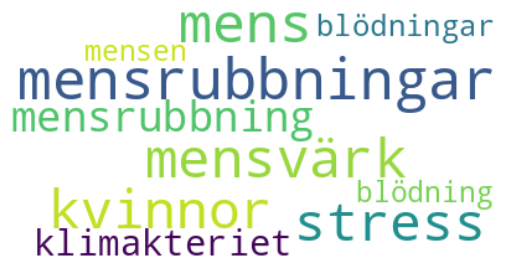

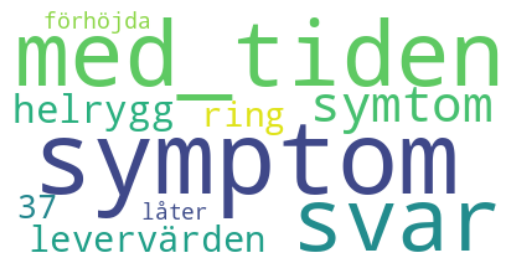

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=17)
create_wordcloud(topic_model, topic=25)

### Heatmaps and Similarity Matrix
Visualize a heatmap of the topic's similarity matrix. Based on the cosine similarity matrix between topic embeddings, a heatmap is created showing the similarity between topics.

In [ ]:
topic_model.visualize_heatmap(top_n_topics=36, width=1000, title='<b>Similarity Matrix: Flashback COVID-19 vaccination dataset</b>',custom_labels=True)

In [ ]:
topic_model.visualize_heatmap(n_clusters=10, width=1000,title='<b>Similarity Matrix: Flashback COVID-19 vaccination dataset</b>', custom_labels=True) #   custom_labels=True) #Create n clusters and order the similarity matrix by those clusters.

### Dynamic topic modeling - evolution of topics over time

Traditional topic models were eventually extended and developed to answer more complex research questions. One such branch of topic modeling was the [Dynamic Topic Model (DTM)](https://en.wikipedia.org/wiki/Dynamic_topic_model). DTM's introduced *time* as a variable, in order to analyze the evolution of topics over time.

In BERTopic, we can emulate DTM provided that we have a time variable, using the `.topics_over_time()` method. We need to provide both the original documents, and their corresponding timestamps to this method.

### Topic Reduction after Training
We can reduce the number of topics after having trained a BERTopic model. The advantage of doing so is that you can decide the number of topics after knowing how many are created. It is difficult to predict before training your model how many topics that are in your documents and how many will be extracted. Instead, we can decide afterward how many topics seem realistic.

### Visualizations


## Extras for the interested

The BERTopic package's `.get_representative_docs()` method only returns 3 representative documents.

We might be interested in seeing more documents that are related to a particular topic. We can create our own function to do just that.

In [ ]:
# First save the topics and documents to a dataframe.
df_docs = pd.DataFrame({'topic': topics, 'document': documents})

In [ ]:
def get_representative_docs(df, topic_nr, n_docs):
  """
  This function randomly samples documents belonging to a given topic.
  """
  df = df[df["topic"] == topic_nr]
  df = df.sample(n_docs) # Randomly sample n_docs from topic
  return df["document"].tolist()

In [ ]:
#get_representative_docs(df_docs, topic_nr=2, n_docs=5)
topic_model.get_representative_docs(topic=10)

["Pfizer's drug is designed to block the activity of a key enzyme that is needed for the coronavirus to multiply.2 Det finns redan medel för att hindra replikation av viruset, men det går inte att patentera och Pfizers nya piller lär bli mycket dyrare. Det blir intressant att se om Pfizers piller blir mer effektivt, ribban ligger högt med CBD. Strikingly, only 1.2% of the patients prescribed CBD contracted SARS-CoV-2 whereas 12.2% of the matched, non-cannabinoid patients tested positive (p=0.009), suggesting a potential reduction in SARS-CoV-2 infection risk of approximately an order of magnitude. URL Dessutom så har du missat att Molnupiravir som är Pfizers nya medicin, fungerar på nästan samma sätt som ivermectin. The RdRP residing in nsp12 is the centerpiece of the coronavirus replication and transcription complex and has been suggested as a promising drug target as it is a crucial enzyme in the virus life cycle both for replication of the viral genome but also for transcription of 

If we instead are interested in finding the most representative documents. We can sort the documents according to the probabilities they have been assigned by BERTopic to belong to a specific cluster/topic and fetch the top results. We do this by creating a function called `get_most_representative_docs`.

In [ ]:
def get_most_representative_docs(probs, df, topic_nr, n_docs=5):
  """
  This function selects the top most representative documents of a topic
  (according to BERTopic).
  """

  top_idx = probs[:, topic_nr].argsort()[::-1]
  return df.loc[top_idx[0:n_docs], "document"].tolist()

In [ ]:
get_most_representative_docs(probs, df_docs, topic_nr=20, n_docs=10)

['Gränsvärdena är ett skämt. De är satta för att undvika engelska_sjukan (D-vitamin) och skörbjugg (C-vitamin). Man bör snarare sikta på 10_000 IE vitamin-D per dag och flera gram C-vitamin per dag.',
 'När det gäller vitamin-D har jag läst om ett enda fall av biverkningar. Då handlade det om 50_000 IE per dag under flera månader. När_det_gäller C-vitamin så kissar man ut överskottet.',
 'Scientists have found that vitamin-D is crucial to activating our immune defenses and that without sufficient intake of the vitamin - the killer cells of the immune system -- T cells -- will not be able to react to and fight off serious infections in the body. The research team found that T cells first search for vitamin-D in order to activate and if they cannot find enough of it will not complete the activation process. URL',
 'Det beror på att ni läkare inte fått läsa på om vitamin-D tillräckligt. Dessutom är ni väl bakbundna av socialstyrelsen och regeringen och vågar därför inte agera utanför dera

We highly recommend checking out the well written documentation of [BERTopic](https://maartengr.github.io/BERTopic/index.html) if you are interested in exploring more.

# Workshop authors

This workshop was created by KBLab, a data lab at the National Library of Sweden. The following members from KBLab participated in creating and presenting different segments of the workshop:

**Faton Rekathati** (Notebook, code, visualizations)  
**Chris Haffenden**  (Interpretation of results, feedback on notebook)    
**Love Börjeson**  (Introduction to topic modeling)  
Adaptations (Jan-Feb 2024) by:
**Dimitrios Kokkinakis**  (New data; stopwords; some new visualiztions...)  